## Final Project - Wine Clustering

Hello and welcome to my project for the unsupervised machine learning final. In this project we will analyze the wine dataset which identifies 13 attributes about three cultivars of wine. Using clustering approaches we will attempt to group the wines based on their attributes into three distinct cultivars. We will use k-means clustering, agglomerative clustering and PCA to help achieve this result. While this is a primarily unsupervised approach, we do have data labels and can analyze the results of our clustering algorithms to find which are the best methods. First we will begin with data preprocessing and EDA, then model training and evaluation, and then a discussion of the results. Thanks for joining me today as we explore the wine dataset!

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [61]:
wine = pd.read_csv('wine-clustering.csv')

In [62]:
wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [63]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


As we can see in the above chunks, our data has 13 different attributes, all measuring different parts of each wine. We have 178 total wines and no missing values. Our data is already formatted correctly so the preprocessing step for EDA is straightforward. Moving on, we can see below how all of the 13 variables are correlated. Ash Alcanity is negatibely correlated with many of the variables except for nonflavanoid phenols which could signal an important pattern. Phenols and flavanoids are very correlated and also signal an important pattern we may see later. All these variables seem to play a role with each other, and it will be critical to understand the patterns for our clustering approach. Below the heatmap, we can see a histogram for each of the features, where phenols, flavanoids, nonflavanoids, alcohol and ash alcanity all have distinct humps in the graph, signaling potential differences among the three cultivars with these features. 

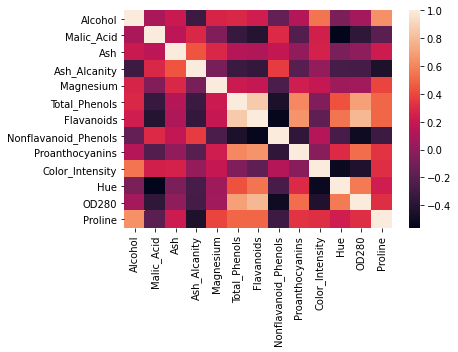

In [65]:
sns.heatmap(wine.corr())

Text(0.5, 1.0, 'Alcohol Distribution')

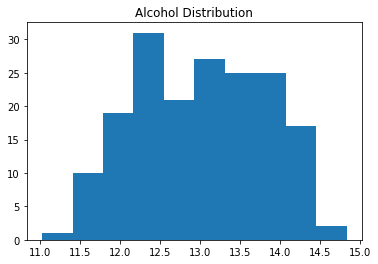

In [6]:
plt.hist(wine['Alcohol'])
plt.title("Alcohol Distribution")

Text(0.5, 1.0, 'Malic Acid Distribution')

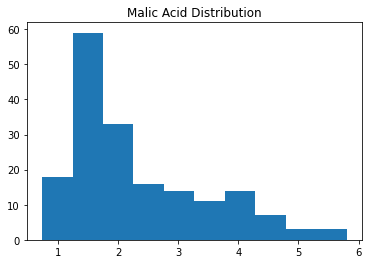

In [8]:
plt.hist(wine['Malic_Acid'])
plt.title("Malic Acid Distribution")

Text(0.5, 1.0, 'Ash Distribution')

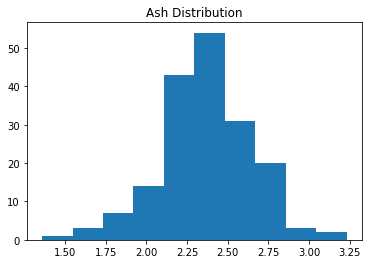

In [9]:
plt.hist(wine['Ash'])
plt.title("Ash Distribution")

Text(0.5, 1.0, 'Ash Alcanity Distribution')

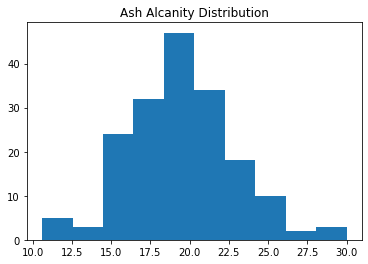

In [11]:
plt.hist(wine['Ash_Alcanity'])
plt.title("Ash Alcanity Distribution")

Text(0.5, 1.0, 'Magnesium Distribution')

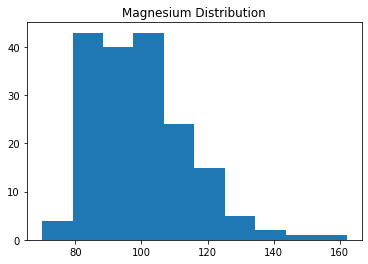

In [12]:
plt.hist(wine['Magnesium'])
plt.title("Magnesium Distribution")

Text(0.5, 1.0, 'Total Phenols Distribution')

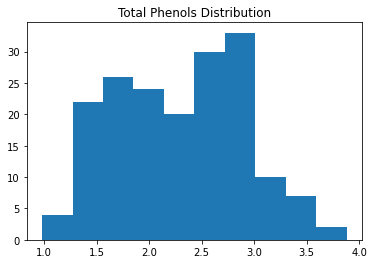

In [13]:
plt.hist(wine['Total_Phenols'])
plt.title("Total Phenols Distribution")

Text(0.5, 1.0, 'Flavanoids Distribution')

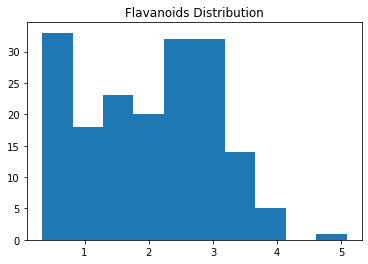

In [14]:
plt.hist(wine['Flavanoids'])
plt.title("Flavanoids Distribution")

Text(0.5, 1.0, 'Nonflavanoid Phenols Distribution')

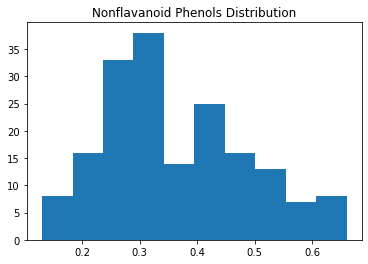

In [15]:
plt.hist(wine['Nonflavanoid_Phenols'])
plt.title("Nonflavanoid Phenols Distribution")

Text(0.5, 1.0, 'Proanthocyanin Distribution')

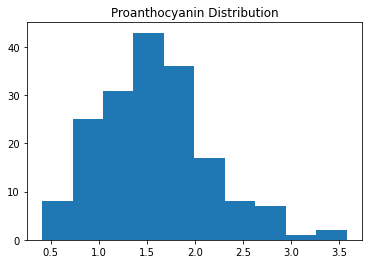

In [16]:
plt.hist(wine['Proanthocyanins'])
plt.title("Proanthocyanin Distribution")

Text(0.5, 1.0, 'Color Intensity Distribution')

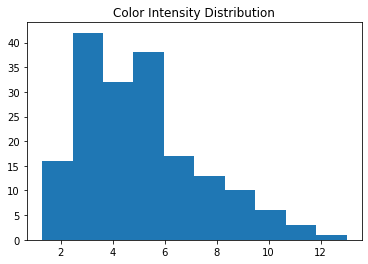

In [19]:
plt.hist(wine['Color_Intensity'])
plt.title("Color Intensity Distribution")

Text(0.5, 1.0, 'Hue Distribution')

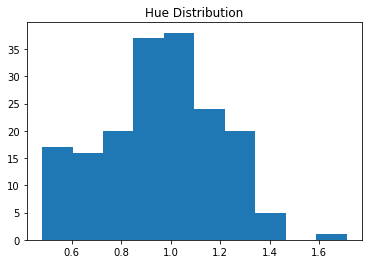

In [20]:
plt.hist(wine['Hue'])
plt.title("Hue Distribution")

Text(0.5, 1.0, 'OD280 Distribution')

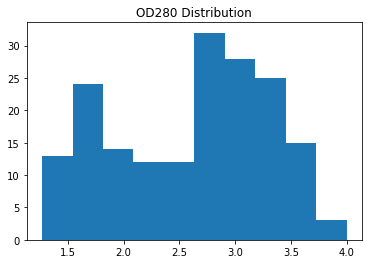

In [21]:
plt.hist(wine['OD280'])
plt.title("OD280 Distribution")

Text(0.5, 1.0, 'Proline Distribution')

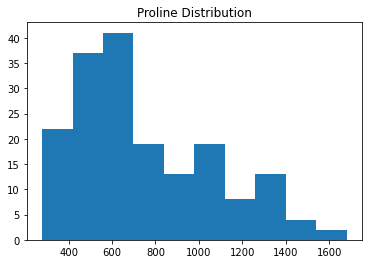

In [23]:
plt.hist(wine['Proline'])
plt.title("Proline Distribution")

## PCA Clustering Kmeans and Agglomerative

This section will now explore our model building approach. Using PCA, we can reduce the number of dimensions to assist our clustering algorithms and reduce any impacts of multicollinearity, and also assist with visualization ability.

Before applying PCA and clustering, it is important to normalize all our variables which we do in the next step. Using sklearn's built in scaler and PCA functions, we can produce our PCA outputs. In the heatmap below we can see the same features as the EDA showing up as important in the first principal component. As expected, these patterns are very important. The first two principal components account for 47% of the total variation which is low, but the following principal components do not assist much either. Because having 2 PCs allows for improved visualization, we will proceed using the first two principal components. 

In [66]:
scaler = StandardScaler()
wine_norm = scaler.fit_transform(wine)

In [67]:
pca = PCA()
wine_pca = pca.fit_transform(wine_norm)

In [68]:
pca.components_

array([[ 0.1443294 , -0.24518758, -0.00205106, -0.23932041,  0.14199204,
         0.39466085,  0.4229343 , -0.2985331 ,  0.31342949, -0.0886167 ,
         0.29671456,  0.37616741,  0.28675223],
       [-0.48365155, -0.22493093, -0.31606881,  0.0105905 , -0.299634  ,
        -0.06503951,  0.00335981, -0.02877949, -0.03930172, -0.52999567,
         0.27923515,  0.16449619, -0.36490283],
       [-0.20738262,  0.08901289,  0.6262239 ,  0.61208035,  0.13075693,
         0.14617896,  0.1506819 ,  0.17036816,  0.14945431, -0.13730621,
         0.08522192,  0.16600459, -0.12674592],
       [-0.0178563 ,  0.53689028, -0.21417556,  0.06085941, -0.35179658,
         0.19806835,  0.15229479, -0.20330102,  0.39905653,  0.06592568,
        -0.42777141,  0.18412074, -0.23207086],
       [-0.26566365,  0.03521363, -0.14302547,  0.06610294,  0.72704851,
        -0.14931841, -0.10902584, -0.50070298,  0.13685982, -0.07643678,
        -0.17361452, -0.10116099, -0.1578688 ],
       [-0.21353865, -0.536813

In [45]:
pca.explained_variance_ratio_

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019,
       0.01736836, 0.01298233, 0.00795215])

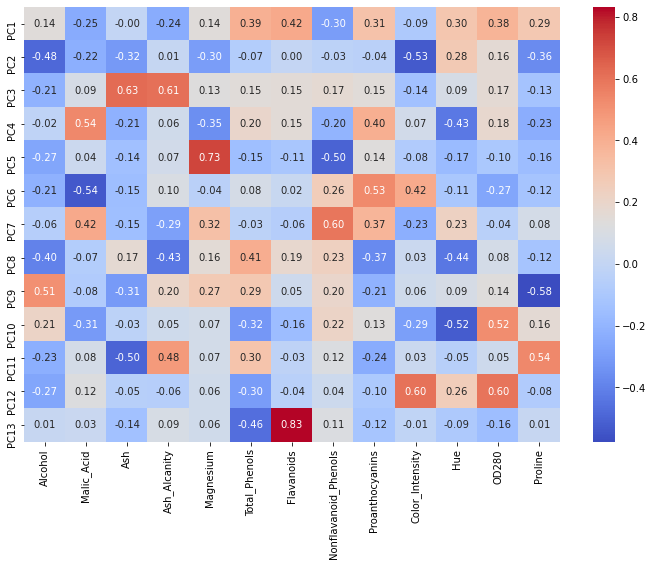

In [71]:
loadings_df = pd.DataFrame(pca.components_, columns=wine.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])

plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f")

In [46]:
#Using first 2 PCA for visualization
pca2 = PCA(n_components = 2)
wine_pca2 = pca2.fit_transform(wine_norm)


This section involves using the PCA adjusted data with kmeans clustering. Visualizing the 3 clusters with our PCA breakout shows clear separation of the three cultivars. Using PCA approach compared to a non PCA approach has already allowed kmeans clustering to improve accuracy by 4% (evaluation discussed at end). 

In [99]:
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(wine_pca2)

Text(0, 0.5, 'PCA Component 2')

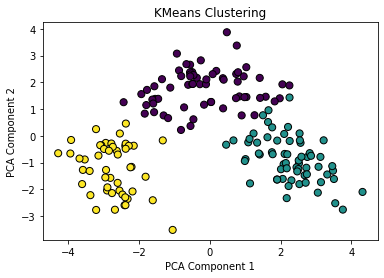

In [49]:
plt.scatter(wine_pca2[:, 0], wine_pca2[:, 1], c=kmeans_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

Using an agglomerative approach tuned by the linkage type is shown below. The ward linkage significantly improves accuracy and separation compared to the single, complete, and average linkage types. It appears agglomerative clustering may slightly improve on kmeans clustering but evaluation will allow us to see at the end of this section. Both types of clustering resulted in clear separation along our principal components and appear to have identified the cultivars well.

In [118]:
agg = AgglomerativeClustering(n_clusters=3, linkage = 'ward')
agg_labels = agg.fit_predict(wine_pca2)

Text(0, 0.5, 'PCA Component 2')

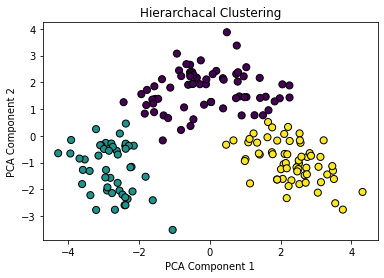

In [119]:
plt.scatter(wine_pca2[:, 0], wine_pca2[:, 1], c=agg_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('Hierarchacal Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

In [75]:
#Evaluation

eval = pd.DataFrame([1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
2,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3,
3])

In [100]:
eval
kmeans_labels
kmeans_labels[kmeans_labels == 2] += 1
kmeans_labels[kmeans_labels == 0] += 2
kmeans_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=int32)

In [101]:
print(confusion_matrix(eval, kmeans_labels))
accuracy_score(eval, kmeans_labels)

[[59  0  0]
 [ 5 65  1]
 [ 0  0 48]]


0.9662921348314607

In [121]:
agg_labels
agg_labels[agg_labels == 1] += 2
agg_labels[agg_labels == 2] -= 1
agg_labels[agg_labels == 0] += 2


In [122]:
print(confusion_matrix(eval, agg_labels))
accuracy_score(eval, agg_labels)

[[58  1  0]
 [ 3 67  1]
 [ 0  1 47]]


0.9662921348314607

This section includes the evaluation of our clustering approaches. While labels are not common with unsupervised learning, we are able to evaluate our model in this circumstance because labels are available. Here we can examine the unsupervised approach accuracy. Our best 2 models are built using 2 principal componenets as shown in the previous section with either agglomerative clustering using ward linkage or the kmeans approach and result in equivalent accuracy at 96.6%, a very strong modeling approach. Using data that was not PCA transformed results in a modeling accuracy of 92.5% for kmeans and 92.3% for agglomerative clustering. Tuning the agglomerative clustering approach with differnet linkage types proves difficult, with single linkage resulting in an accuracy of 11%, complete linkage with 92.0% and average linkage at 94.6%. After tuning our models we can see teh best approach includes using PCA, which is important for improving either clustering approach and its efficiency, as well as allowing us to visualize the data feasibly. 

We see that using PCA combined with clustering is very key in this dataset, and has allowed us to identify wine cultivars using the wine's attribute. Future wine could be quickly identified using this clustering approach, by understanding the new wine's attributes. Thank you for joining me today as we explored the wine dataset and how the data could be modeled using both PCA and clustering for a high accuracy model. Thank you!